Name: Charles Fawcett

Student ID: 14247617

ALL import statements


In [385]:
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
from sklearn import tree, metrics


ALL custom functions:

In [ ]:
#helper to calculate descriptive statistics for a column of returns in a dataframe
def quartile_performance(data: pd.DataFrame, return_name: str = "fut_ret") -> pd.DataFrame:
    mean_return = data[return_name].mean()*12
    volatility = data[return_name].std()*np.sqrt(12)
    rr_ratio = (data[return_name].mean()*12) / (data[return_name].std()*np.sqrt(12))
    performance = pd.DataFrame({'Mean Ret': mean_return,
                                'Std Dev': volatility,
                                'RR Ratio': rr_ratio})
    return performance

#helper to calculate information coefficient
def monthly_ic(df, factor):
    #df indexed by ['id','date'] with columns [factor, 'fut_ret']
    #Spearman IC per month
    return (df[[factor, 'fut_ret']]
            .dropna()
            .groupby('date')
            .apply(lambda x: x[factor].corr(x['fut_ret'], method='spearman'))
            .rename(f'{factor}_IC'))

#helper to show a dollar invested - only formatting no data processing
def one_dollar_invested_plot(df: pd.DataFrame, title: str, legend_map: dict | None = None, save_as: None | str = None) -> None:
    ax = df.plot(figsize=(10, 6))
    ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio Value ($, Log Scale)")
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))
    ax.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
    ax.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
    ax.tick_params(axis='x', labelrotation=0)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('center')
    ax.figure.tight_layout()

    #remap legend labels
    if legend_map is not None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, [legend_map.get(l, l) for l in labels])

    if save_as:
        ax.figure.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(ax.figure)

#shortcut function to remove repeated code for training a decision tree
def train_tree(data: pd.DataFrame, prices: pd.DataFrame, train_start_date: str = '1990-01-01', train_end_date: str = '2014-12-31', test_start_date: str = '2015-01-01', test_end_date: str = '2023-12-29', y_col: str = 'fut_ret', depth: int = 3):
    #create the features by remivng the returns
    X = data.drop(columns=[y_col])

    #convert the returns into category labels that a decision tree can use, in this case if the return is above the median that month
    y = data[y_col] > data.groupby('date')[y_col].transform('median')

    #split into test and train sets based on the parsed start and end dates
    X_train = X.loc[pd.IndexSlice[:, train_start_date:train_end_date],:]
    X_test = X.loc[pd.IndexSlice[:, test_start_date:test_end_date],:]
    y_train = y.loc[pd.IndexSlice[:, train_start_date:train_end_date]]
    y_test = y.loc[pd.IndexSlice[:, test_start_date:test_end_date]]
    
    #initialise and fit a tree
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    #calculate the feature importance
    features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)

    #in sample predictions
    y_train_pred = clf.predict(X_train)

    #Out of sample predictions
    y_test_pred = clf.predict(X_test)

    #convert numpy series to dataframes
    os_pred = pd.Series(y_test_pred.astype('int64'), index = X_test.index).rename('Winner')
    ins_pred = pd.Series(y_train_pred.astype('int64'), index = X_train.index).rename('Winner')
    
    #calculate performance stats
    ret, os_dia = ap.ml_analysis(os_pred, prices.squeeze())
    print(os_dia)

    #grab the information ratio from the stats
    ir = os_dia.loc['RR Ratio', 'Active']

    #calculate the accuracy
    ins_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    os_accuracy = metrics.accuracy_score(y_test, y_test_pred)

    print(f'in sample accuracy: {ins_accuracy}, out of sample accuracy: {os_accuracy}')

    return clf, ins_accuracy, os_accuracy, ir, features, X.columns.to_list()

skip optimisation flag added to skip optimisation in section 4 and section 5 which takes around 40 minutes

### Must be False to calculate for relevant sections ###

In [387]:
skip_optimisation_frequency = True #for section 3 frequency optimisation (about 1 minute processing time)
skip_optimisation_combo_strat = True  #for section 5 combination strategy optimisation (about 40mins processing time)

Loading of ALL data files setting mutli-index on id and date and parseing dates


In [388]:
factors = pd.read_csv('FACTORS.zip', parse_dates=['date']).set_index(['id', 'date'])
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])
names = pd.read_csv('names.zip').set_index('id')
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])
inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])
factors.head()

C:\Users\cfawc\AppData\Local\Temp\ipykernel_7152\3986249606.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inflation = pd.read_csv('Inflation.csv', parse_dates=['date']).set_index(['date'])


tvol    profit    safety
id    date                                    
10001 1996-07-31  1.145514 -0.612134 -0.475430
      1996-08-30  1.144505 -0.614493 -0.553341
      1996-09-30  1.144190 -1.327119 -0.697980
      1996-10-31  1.124252 -1.324461 -0.728012
      1996-11-29  1.123180 -1.321322 -0.721799

# 1. PREDICTIVE POWER OF INVESTMENT FACTORS


calculating the future returns and storing this in a series

In [ ]:
#calculating the future returns and storing this in a series
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

#split each factor into their own series
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#head for 1 of the 3 for demonstration
tvol_data.head()

tvol   fut_ret
id    date                          
10001 1996-07-31  1.145514  0.037458
      1996-08-30  1.144505  0.040916
      1996-09-30  1.144190 -0.028987
      1996-10-31  1.124252  0.028988
      1996-11-29  1.123180 -0.061268

number of bins for the quintile analysis:


In [390]:
N = 4

Create the bins

In [391]:
#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)

#join the future returns onto the group data and leave na values
data = groups.join(future_returns).dropna(subset=['fut_ret'])
data.tail()

tvol_group  profit_group  safety_group   fut_ret
id    date                                                        
93426 2023-08-31           3             3             4 -0.070144
      2023-09-29           3             3             4 -0.115403
      2023-10-31           3             3             4  0.018872
      2023-11-30           3             3             4  0.111019
      2023-12-29           3             3             4 -0.066438

calculate and format the data to show in the aar_bar_chart 

In [ ]:
#calculate the average signal and the average future return and pass this to the quartile_performance function
tvol_perf = quartile_performance(tvol_data.groupby(['date', 'tvol_group']).mean().unstack(level=1))
profit_perf = quartile_performance(profit_data.groupby(['date', 'profit_group']).mean().unstack(level=1))
safety_perf = quartile_performance(safety_data.groupby(['date', 'safety_group']).mean().unstack(level=1))

#benchmark performance (grabbing fut_ret data from tvol)
avg_benchmark_returns = tvol_data['fut_ret'].mean()*12
benchmark_rr_ratio = (tvol_data['fut_ret'].mean()*12) / (tvol_data['fut_ret'].std()*np.sqrt(12))

bar_chart_col_names = [f"bucket {i+1}" for i in range(N)]
aar_bar_chart_df = pd.DataFrame({
    'Volatility': tvol_perf['Mean Ret'],
    'Profit': profit_perf['Mean Ret'],
    'Safety': safety_perf['Mean Ret']
})

aar_bar_chart_df.index = bar_chart_col_names

print(aar_bar_chart_df)

          Volatility    Profit    Safety
bucket 1   -0.021710 -0.018614 -0.024625
bucket 2    0.045205  0.050647  0.057596
bucket 3    0.068058  0.070356  0.073744
bucket 4    0.099548  0.088744  0.084439


creating and beautifying the "Average Annual Returns vs Quantile Bucket for Investment Factors" figure (rrr)


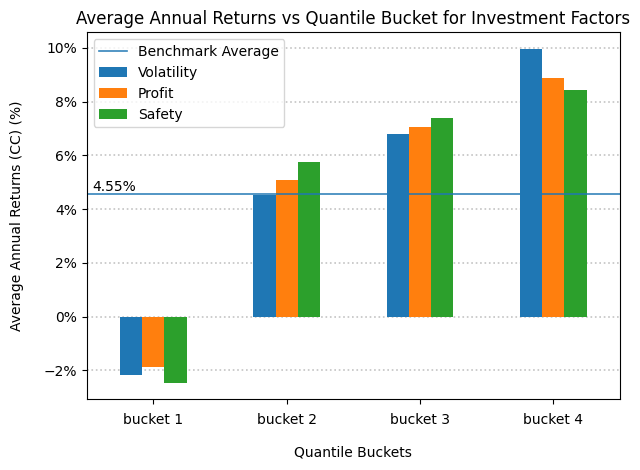

In [ ]:
aar_bar_chart = aar_bar_chart_df.plot(kind='bar', rot=0)
aar_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
aar_bar_chart.set_ylabel("Average Annual Returns (CC) (%)", labelpad=14)
aar_bar_chart.set_title("Average Annual Returns vs Quantile Bucket for Investment Factors")
aar_bar_chart.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0)) #used so that the y axis shows 5% instead of 0.05

#adding the benchmark average as a line across the bar chart
aar_bar_chart.axhline(y=avg_benchmark_returns, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark Average')
aar_bar_chart.text(0.01, avg_benchmark_returns, f'{avg_benchmark_returns:.2%}',
        transform=aar_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
aar_bar_chart.legend()

aar_bar_chart.set_axisbelow(True)
aar_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in aar_bar_chart.get_xticklabels():
    lbl.set_ha('center')   # default for bars, but explicit is fine
aar_bar_chart.tick_params(axis='x', pad=6)  # a little space from the axis
aar_bar_chart.figure.tight_layout()

calculate and format the data to show in the rrr_bar_chart 

In [394]:
rrr_bar_chart = pd.DataFrame({
    'Volatility': tvol_perf['RR Ratio'],
    'Profit': profit_perf['RR Ratio'],
    'Safety': safety_perf['RR Ratio']
})

rrr_bar_chart.index = bar_chart_col_names

print(rrr_bar_chart)

          Volatility    Profit    Safety
bucket 1   -0.089738 -0.089384 -0.100764
bucket 2    0.222275  0.273289  0.316513
bucket 3    0.366419  0.390119  0.422400
bucket 4    0.736208  0.512062  0.565365


setup and creating the "Risk to Reward ratio vs Quintile Bucket for Investment Factors" (rrr)


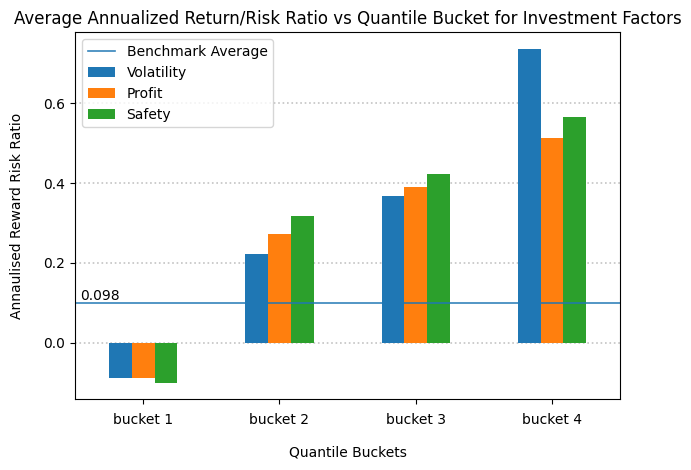

In [395]:
rrr_bar_chart = rrr_bar_chart.plot(kind='bar', rot=0)
rrr_bar_chart.set_xlabel("Quantile Buckets", labelpad=14)
rrr_bar_chart.set_ylabel("Annaulised Reward Risk Ratio", labelpad=14)
rrr_bar_chart.set_title("Average Annualized Return/Risk Ratio vs Quantile Bucket for Investment Factors")

#adding the benchmark line
rrr_bar_chart.axhline(y=benchmark_rr_ratio, linestyle='-', linewidth=1.2, alpha=0.9, label='Benchmark Average')
rrr_bar_chart.text(0.01, benchmark_rr_ratio, f'{benchmark_rr_ratio:.2}',
        transform=rrr_bar_chart.get_yaxis_transform(),
        ha='left', va='bottom', clip_on=False)
rrr_bar_chart.legend()

rrr_bar_chart.set_axisbelow(True)
rrr_bar_chart.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
for lbl in rrr_bar_chart.get_xticklabels():
    lbl.set_ha('center')
rrr_bar_chart.tick_params(axis='x', pad=6)
rrr_bar_chart.figure.tight_layout()

save both of the graphs

In [396]:
#figure 1 in report
aar_bar_chart.figure.savefig("aar_bar_chart.png", dpi=150, bbox_inches='tight')

#figure 2 in report
rrr_bar_chart.figure.savefig("rrr_bar_chart.png", dpi=150, bbox_inches='tight')

visualising the the returns on a $1 portfolio in each bucket and factor
shown in APPENDIX A - $1 INVESTED IN FACTOR BUCKETS in the report

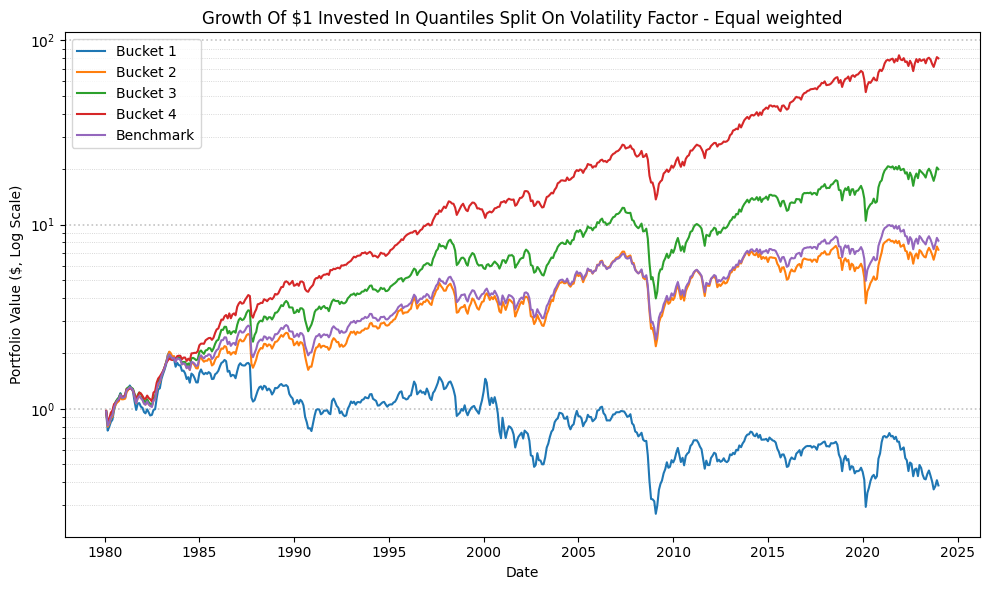

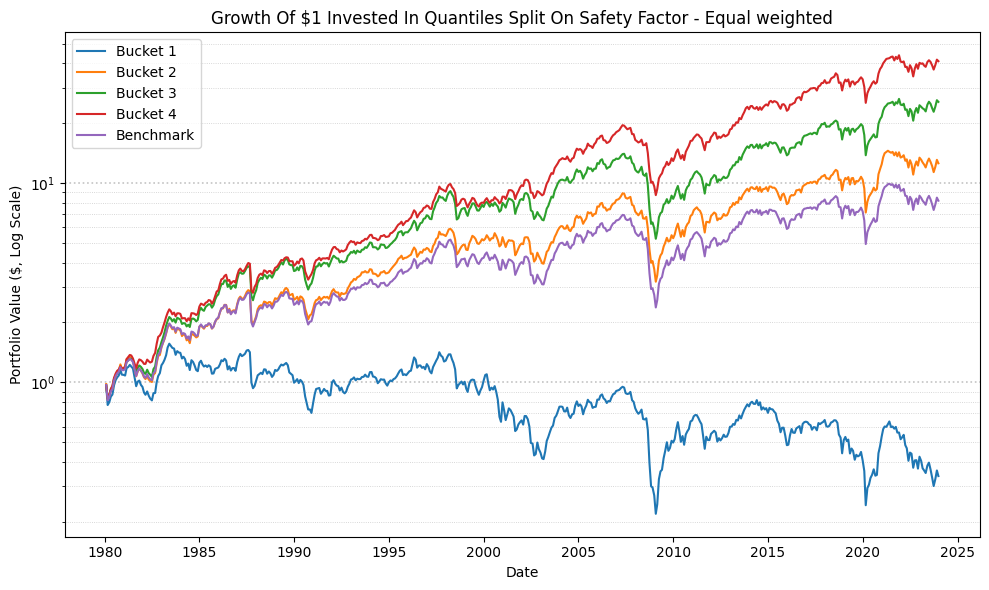

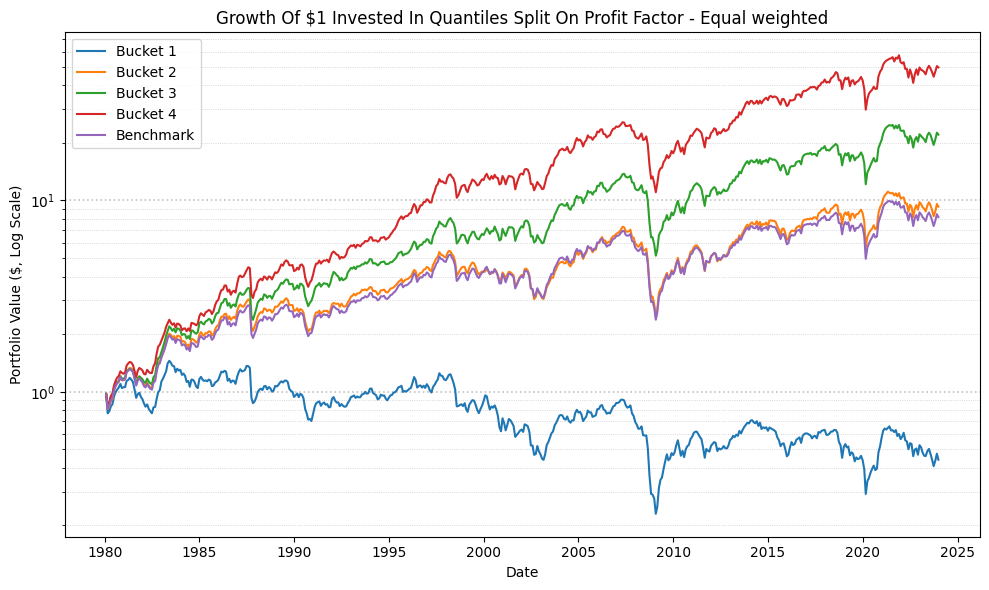

In [397]:
#calculating for benchmark
bench_port = data['fut_ret'].groupby('date').mean().cumsum().apply(np.exp).to_frame()

#calculating for volatility and adding benchmark
tvol_port = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
tvol_port = tvol_port.join(bench_port)

#calculating for safety and adding benchmark
safety_port = data.groupby(['date', 'safety_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
safety_port = safety_port.join(bench_port)

#calculating for profit and adding benchmark
profit_port = data.groupby(['date', 'profit_group']).mean().unstack(level=1)['fut_ret'].cumsum().apply(np.exp)
profit_port = profit_port.join(bench_port)

#creating a legend map so that the legend show nice and tidy e.g -"Bucket 1"
legend_map = {}
for i in range(0, N):
    legend_map[f"{i+1}"] = f"Bucket {i+1}"
legend_map["fut_ret"] = "Benchmark"

#plot each factor (and save - these are in the appendix and not the main body of the report)
one_dollar_invested_plot(tvol_port, "Growth Of $1 Invested In Quantiles Split On Volatility Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Volatility Factor - Equal weighted.png")
one_dollar_invested_plot(safety_port, "Growth Of $1 Invested In Quantiles Split On Safety Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Safety Factor - Equal weighted.png")
one_dollar_invested_plot(profit_port, "Growth Of $1 Invested In Quantiles Split On Profit Factor - Equal weighted", legend_map=legend_map, save_as="Growth Of $1 Invested In Quantiles Split On Profit Factor - Equal weighted.png")

Year by year (yby) performance by looking at the differnce between bucket 4 and the benchmark year by year for each factor


In [ ]:
#create benchmark return dataframe
benchmark_ret = data['fut_ret'].groupby('date').mean().to_frame()

#for each factor we...
#generate a dataframe indexed by date with a column per group with average returns instead of per id
tvol_active = data.groupby(['date', 'tvol_group']).mean().unstack(level=1)["fut_ret"]
#add on the benchmark
tvol_active = tvol_active.join(benchmark_ret).dropna()
#create the active return by grabbing the last bucket if N=4 4th bucket and subtracting benchmark
tvol_active["active"] = tvol_active[N] - tvol_active["fut_ret"]
#resample to yearly by summing monthly data and then convert to annual simple return
tvol_yby = tvol_active.resample('YE').sum().apply(np.expm1)
#replace datetimeindex with plain integers
tvol_yby.index = tvol_yby.index.year

#see tvol comments as the same proces is applied to the other 2 factors
safety_active = data.groupby(['date', 'safety_group']).mean().unstack(level=1)["fut_ret"]
safety_active = safety_active.join(benchmark_ret).dropna()
safety_active["active"] = safety_active[N] - safety_active["fut_ret"]
safety_yby = safety_active.resample('YE').sum().apply(np.expm1)
safety_yby.index = safety_yby.index.year

profit_active = data.groupby(['date', 'profit_group']).mean().unstack(level=1)["fut_ret"]
profit_active = profit_active.join(benchmark_ret).dropna()
profit_active["active"] = profit_active[N] - profit_active["fut_ret"]
profit_yby = profit_active.resample('YE').sum().apply(np.expm1)
profit_yby.index = profit_yby.index.year

#take the active returns and put them in a dataframe for future use
actives = pd.DataFrame()
actives["tvol"] = tvol_active['active'] 
actives["safety"] = safety_active['active'] 
actives["profit"] = profit_active['active'] 

#showing example of processed factor data
tvol_yby.head()

,1,2,3,4,fut_ret,active
date,,,,,,
1980,0.158119,0.128844,0.158787,0.160211,0.151364,0.007684
1981,-0.124576,-0.000901,-0.000217,0.014295,-0.029595,0.045228
1982,0.433360,0.344524,0.307166,0.318168,0.349994,-0.023575
1983,0.185707,0.231139,0.239483,0.252342,0.226915,0.020724
1984,-0.091176,-0.004010,0.086508,0.140113,0.028998,0.107984


show the data in tidy bar charts figure 3 through 5 in the report

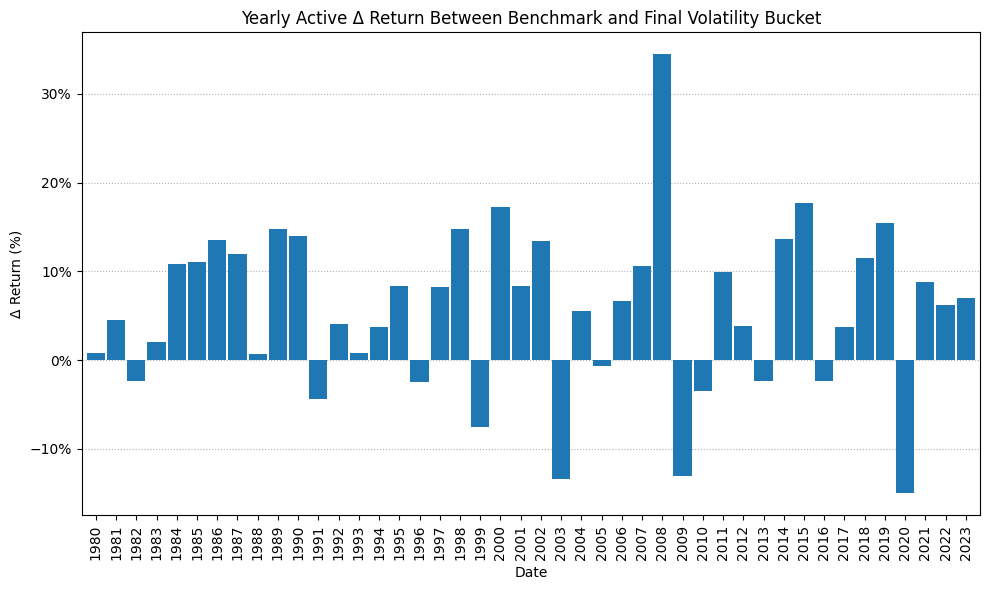

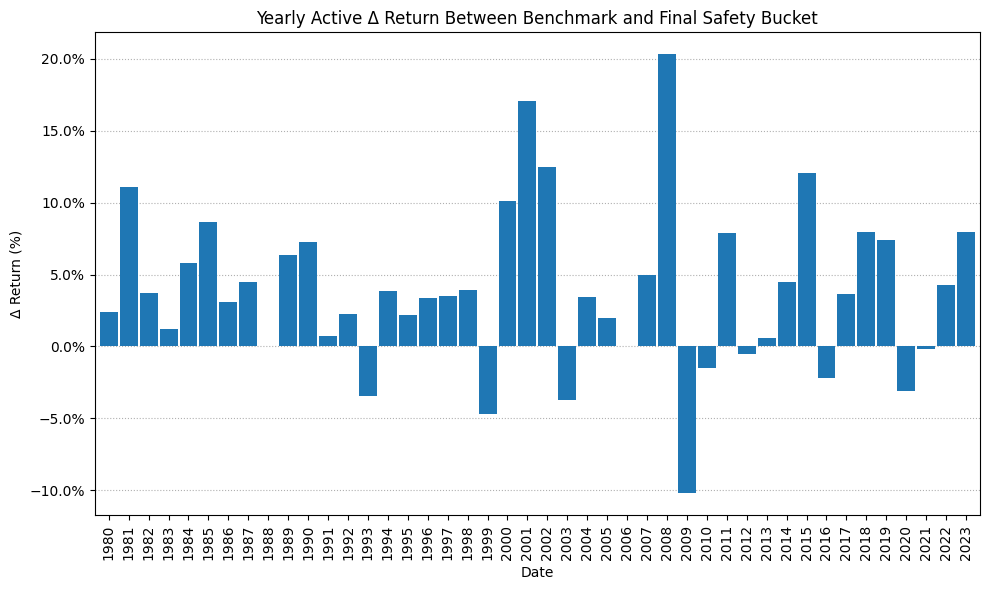

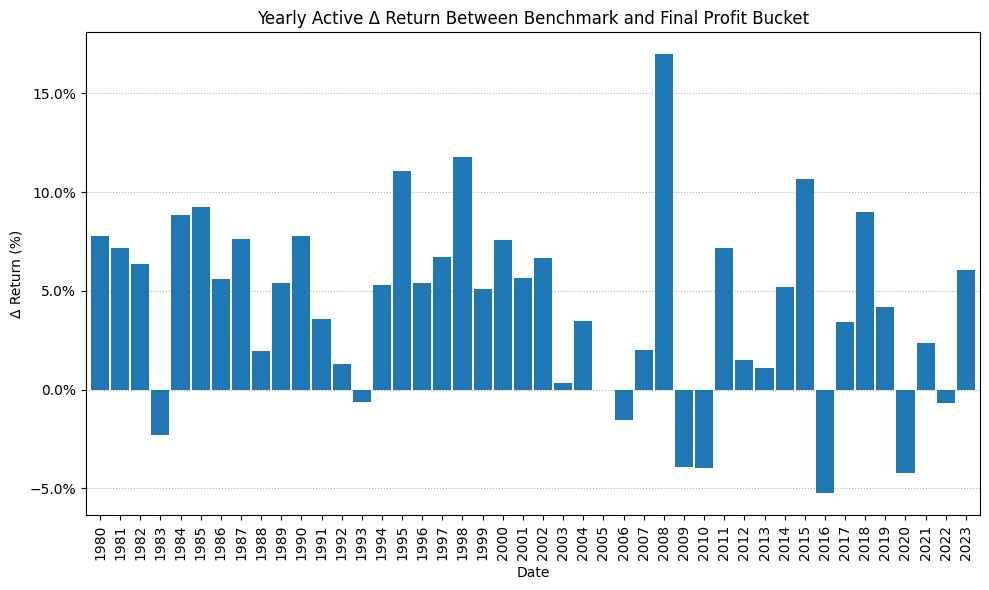

In [ ]:
#bar charts
tvol_yby_bar_return = tvol_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
tvol_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Volatility Bucket")
tvol_yby_bar_return.set_xlabel("Date")
tvol_yby_bar_return.set_ylabel("Δ Return (%)")
tvol_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
tvol_yby_bar_return.set_axisbelow(True)
tvol_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
tvol_yby_bar_return.figure.savefig("tvol_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()

safety_yby_bar_return = safety_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
safety_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Safety Bucket")
safety_yby_bar_return.set_xlabel("Date")
safety_yby_bar_return.set_ylabel("Δ Return (%)")
safety_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
safety_yby_bar_return.set_axisbelow(True)
safety_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
safety_yby_bar_return.figure.savefig("safety_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()

profit_yby_bar_return = profit_yby['active'].plot(figsize=(10,6), kind='bar', width=0.9)
profit_yby_bar_return.set_title("Yearly Active Δ Return Between Benchmark and Final Profit Bucket")
profit_yby_bar_return.set_xlabel("Date")
profit_yby_bar_return.set_ylabel("Δ Return (%)")
profit_yby_bar_return.grid(True, axis='y', linestyle=':', linewidth=0.8)
profit_yby_bar_return.set_axisbelow(True)
profit_yby_bar_return.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
profit_yby_bar_return.figure.savefig("profit_yby_bar_return.png", dpi=150, bbox_inches='tight')
plt.show()

Now to calculate the correlation between the factors for the Factor Correlation section of section 1. of the report (36 month rolling correlation of top bucket returns)

In [400]:
roll_corr = pd.DataFrame()
roll_corr['tvol_safety'] = actives['tvol'].rolling(36).corr(actives['safety'])
roll_corr['tvol_profit'] = actives['tvol'].rolling(36).corr(actives['profit'])
roll_corr['safety_profit'] = actives['safety'].rolling(36).corr(actives['profit'])

averages = [roll_corr['tvol_safety'].mean(), roll_corr['tvol_profit'].mean(), roll_corr['safety_profit'].mean()]

print(roll_corr)
print('averages:')
print(averages)

            tvol_safety  tvol_profit  safety_profit
date                                               
1980-01-31          NaN          NaN            NaN
1980-02-29          NaN          NaN            NaN
1980-03-31          NaN          NaN            NaN
1980-04-30          NaN          NaN            NaN
1980-05-30          NaN          NaN            NaN
...                 ...          ...            ...
2023-08-31     0.798549     0.564765       0.614780
2023-09-29     0.811130     0.568428       0.630930
2023-10-31     0.768492     0.522038       0.603114
2023-11-30     0.773048     0.530540       0.613493
2023-12-29     0.755612     0.454262       0.582451

[528 rows x 3 columns]
averages:
[np.float64(0.6218794945892321), np.float64(0.41758780350651825), np.float64(0.5695087901530785)]


making the very nice and tidy graph (figure 6)

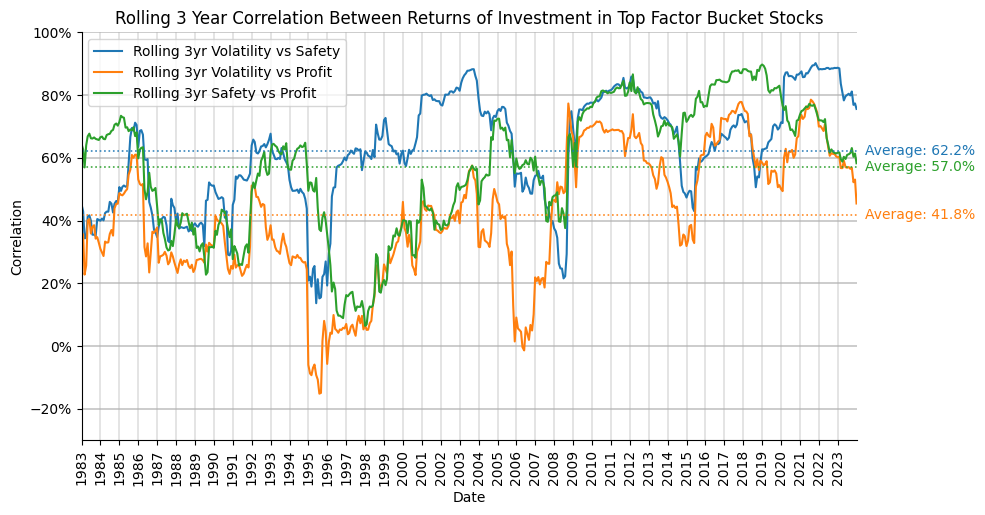

In [401]:
roll_corr_plot = roll_corr.plot(figsize=(10, 6))
roll_corr_plot.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
roll_corr_plot.set_ylim(-.3, 1)
roll_corr_plot.tick_params(axis='x', labelrotation=90)
roll_corr_plot.spines['top'].set_visible(False)
roll_corr_plot.spines['right'].set_visible(False)
first_valid = roll_corr.index[roll_corr.notna().any(axis=1)][0]
roll_corr_plot.xaxis.set_major_locator(mdates.YearLocator(base=1, month=1, day=1))
roll_corr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
roll_corr_plot.set_xlim(left=first_valid, right=roll_corr.index.max())  # no extra room on the right
roll_corr_plot.margins(x=0) 

#changing the legend titles that show up on the graph
legend_map = {
        "tvol_safety" : "Rolling 3yr Volatility vs Safety",
        "tvol_profit" : "Rolling 3yr Volatility vs Profit",
        "safety_profit" : "Rolling 3yr Safety vs Profit",
}
handles, labels = roll_corr_plot.get_legend_handles_labels()
roll_corr_plot.legend(handles, [legend_map.get(l, l) for l in labels])

#adding and formatting the average lines that cut across the graph
y = float(averages[0])
c = 'tab:blue'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[1])
c = 'tab:orange'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

y = float(averages[2])
c = 'tab:green'
x0 = roll_corr.index.sort_values()[35]
x1 = roll_corr.index.max()
roll_corr_plot.hlines(y=y, xmin=x0, xmax=x1,colors=c, linestyles=':', linewidth=1.2, alpha=0.9)
roll_corr_plot.annotate(f'Average: {y:.1%}',
                        xy=(1, y),                         # x=right edge of axes
                        xycoords=('axes fraction', 'data'),# x in axes coords, y in data coords
                        xytext=(6, 0), textcoords='offset points',
                        ha='left', va='center',
                        color=c,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'),
                        clip_on=False)

#centerring labels
for lbl in roll_corr_plot.get_xticklabels():
        lbl.set_ha('center')

#setting grid
roll_corr_plot.grid(True, axis='y', linestyle='-', linewidth=1.2, alpha=0.75)
roll_corr_plot.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)
roll_corr_plot.grid(True, axis='x', linestyle='-', linewidth=1.2, alpha=0.4)
roll_corr_plot.grid(True, axis='x', which='minor', linestyle=':', linewidth=0.6, alpha=0.4)

#adding labels
roll_corr_plot.set_xlabel('Date')
roll_corr_plot.set_ylabel('Correlation')
roll_corr_plot.set_title('Rolling 3 Year Correlation Between Returns of Investment in Top Factor Bucket Stocks')

#saving figure
roll_corr_plot.figure.savefig("roll_corr_plot.png", dpi=150, bbox_inches='tight')

raw factor correlation table (table 1 in report)

In [402]:
print(factors.corr('spearman'))

            tvol    profit    safety
tvol    1.000000  0.091074  0.124742
profit  0.091074  1.000000  0.424398
safety  0.124742  0.424398  1.000000


# 2. EFFECT OF MACROECONOMIC ENVIRONMENT


In [403]:
inflation.head()

,Inflation
date,
1980-01-31,13.599493
1980-02-29,14.331667
1980-03-31,14.755205
1980-04-30,15.115273
1980-05-30,15.774167


Setting the inflation state

In [404]:
#Inflation!
# low rate = 0, normal rate = 1, high rate  = 2
inflation['inf_state'] = 1
inflation.loc[inflation["Inflation"] < 1.5, 'inf_state'] = 0
inflation.loc[inflation['Inflation'] >= 3, 'inf_state'] = 2

inflation.head()

,Inflation,inf_state
date,,
1980-01-31,13.599493,2
1980-02-29,14.331667,2
1980-03-31,14.755205,2
1980-04-30,15.115273,2
1980-05-30,15.774167,2


making a nice and tidy graph to show inflation regimes (figure 7 in report)

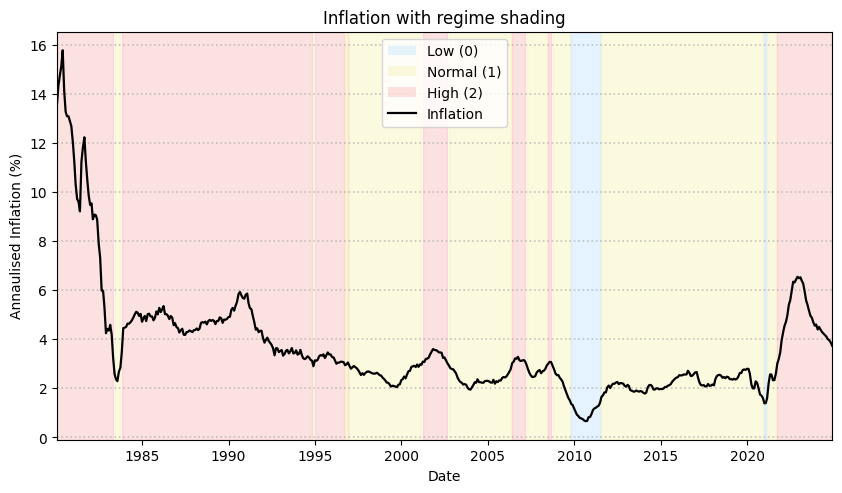

In [ ]:
infl_plt = inflation['Inflation'].plot(figsize=(10,6), lw=1.6, color='black',
                                 title='Inflation with regime shading')

#set x axis to the exact data range
xmin, xmax = inflation.index.min(), inflation.index.max()
infl_plt.set_xlim(xmin, xmax)

#add grid
infl_plt.grid(True, axis='y', linestyle=':', linewidth=1.2, alpha=0.75)
infl_plt.grid(True, axis='y', which='minor', linestyle=':', linewidth=0.6, alpha=0.65)

#colours per state
state_cols = {0: "#b4deff",  # low
              1: "#f4eea3",  # normal
              2: "#f9abab"}  # high

#find contiguos blocks of the same state
blocks = (inflation['inf_state'].ne(inflation['inf_state'].shift())).cumsum()

# shade each block
for _, seg in inflation.groupby(blocks):
    st = int(seg['inf_state'].iloc[0])
    infl_plt.axvspan(seg.index[0], seg.index[-1], color=state_cols[st], alpha=0.35, zorder=0)

#centre and format year labels horizontally
infl_plt.xaxis.set_major_locator(mdates.YearLocator(5))
infl_plt.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#keep labels horizontal and centered
for lbl in infl_plt.get_xticklabels():
    lbl.set_rotation(0)
    lbl.set_ha('center')

#legend for background colours
handles = [Patch(facecolor=state_cols[0], edgecolor='none', alpha=0.35, label='Low (0)'),
           Patch(facecolor=state_cols[1], edgecolor='none', alpha=0.35, label='Normal (1)'),
           Patch(facecolor=state_cols[2], edgecolor='none', alpha=0.35, label='High (2)')]
infl_plt.legend(handles=handles + [infl_plt.lines[0]], labels=[h.get_label() for h in handles] + ['Inflation'],
          loc='best')

#set labels
infl_plt.set_ylabel('Annaulised Inflation (%)')
infl_plt.set_xlabel('Date')

#save the figure
infl_plt.figure.savefig("infl_plt.png", dpi=150, bbox_inches='tight')

calculating the performance of the factors in the different inflation states

In [406]:
#re calculate the buckets (in case N!=4 above) basically same as what is done above!
tvol_series = factors['tvol']
profit_series = factors['profit']
safety_series = factors['safety']

#merge each factor series with the future returns
tvol_data = tvol_series.to_frame().join(future_returns).dropna()
profit_data = profit_series.to_frame().join(future_returns).dropna()
safety_data = safety_series.to_frame().join(future_returns).dropna()

#number of bins for the quartile inflation analysis
N = 4

#create the bins
tvol_data['tvol_group'] = tvol_data.groupby('date', group_keys=False)['tvol'].apply(lambda x: pd.qcut(x,N, labels=False))+1
profit_data['profit_group'] = profit_data.groupby('date', group_keys=False)['profit'].apply(lambda x: pd.qcut(x,N, labels=False))+1
safety_data['safety_group'] = safety_data.groupby('date', group_keys=False)['safety'].apply(lambda x: pd.qcut(x,N, labels=False))+1

#combine into one dataframe
groups = pd.concat(
    [tvol_data[['tvol_group']], profit_data[['profit_group']], safety_data[['safety_group']]],
    axis=1, join='inner'
)
data = groups.join(future_returns).dropna(subset=['fut_ret'])

#join the inflation information
data = data.join(inflation['inf_state'])

data.head()

tvol_group  profit_group  safety_group   fut_ret  inf_state
id    date                                                                   
10001 1996-07-31           4             1             2  0.037458          2
      1996-08-30           4             1             2  0.040916          2
      1996-09-30           4             1             1 -0.028987          1
      1996-10-31           4             1             1  0.028988          1
      1996-11-29           4             1             1 -0.061268          2

Now that we have the data with the groups and the inflation state we find values per group and inflation state

In [407]:
factor_prefixs = ['tvol_', 'profit_', 'safety_'] #for programatically refering to the factors to save code

#for each month and each tvol bucket get the average fut_ret turn the buckets into coluns 1 through 4 
tvol_b_ret = (data.groupby(['date','tvol_group'])['fut_ret'].mean().unstack('tvol_group'))
#rename the columns created in the previous step so they can be id'ed at tvol buckets once joined
tvol_b_ret = tvol_b_ret.add_prefix('tvol_')

#same process as for tvol for profit and safety
profit_b_ret = (data.groupby(['date','profit_group'])['fut_ret'].mean().unstack('profit_group'))
profit_b_ret = profit_b_ret.add_prefix('profit_')

safety_b_ret = (data.groupby(['date','safety_group'])['fut_ret'].mean().unstack('safety_group'))
safety_b_ret = safety_b_ret.add_prefix('safety_')

safety_b_ret.head() #show 1 for example

safety_group,safety_1,safety_2,safety_3,safety_4
date,,,,
1980-01-31,-0.032308,-0.019865,-0.037735,-0.031646
1980-02-29,-0.229455,-0.178240,-0.150201,-0.149299
1980-03-31,0.033367,0.043064,0.040669,0.034470
1980-04-30,0.064034,0.063116,0.071088,0.071391
1980-05-30,0.023629,0.018864,0.023942,0.037039


also get the inflation state from the stock data and add that to the inf_state_returns dataframe with everything from the previous cell

In [408]:
inf = data.groupby('date')['inf_state'].first()
inf_state_returns = tvol_b_ret.join(profit_b_ret).join(safety_b_ret).join(inf)

inf_state_returns.head()

,tvol_1,tvol_2,tvol_3,tvol_4,profit_1,profit_2,profit_3,profit_4,safety_1,safety_2,safety_3,safety_4,inf_state
date,,,,,,,,,,,,,
1980-01-31,-0.036962,-0.034197,-0.027465,-0.022908,-0.042005,-0.030437,-0.022539,-0.026528,-0.032308,-0.019865,-0.037735,-0.031646,2
1980-02-29,-0.233693,-0.187856,-0.156668,-0.128958,-0.218244,-0.178958,-0.155092,-0.154953,-0.229455,-0.178240,-0.150201,-0.149299,2
1980-03-31,0.049574,0.034722,0.035147,0.032064,0.024250,0.033865,0.036209,0.057183,0.033367,0.043064,0.040669,0.034470,2
1980-04-30,0.057606,0.071587,0.066637,0.073799,0.059597,0.066807,0.069425,0.073800,0.064034,0.063116,0.071088,0.071391,2
1980-05-30,0.028232,0.019173,0.030118,0.025979,0.024309,0.020580,0.031000,0.027618,0.023629,0.018864,0.023942,0.037039,2


create an empty data frame and fill it with one column per facter per state (3x3 - hence the nested loop) only using the top bucket from inf_state_returns

In [409]:
#top quartile performance (tqp) for each inflation state
tqp_per_state = pd.DataFrame()

for factor in range(0, 3): #loop over factors
    for state in range(0, 3): #loop over states
        column_name = f'{factor_prefixs[factor]}4_inf{state}' #generate the column name with an f string
        tqp_per_state[column_name] = inf_state_returns[f'{factor_prefixs[factor]}4'].where(inf_state_returns['inf_state'].eq(state))

bench_ret = data['fut_ret'].groupby('date').mean()
tqp_per_state = tqp_per_state.join(bench_ret)

tqp_per_state.head()

,tvol_4_inf0,tvol_4_inf1,tvol_4_inf2,profit_4_inf0,profit_4_inf1,profit_4_inf2,safety_4_inf0,safety_4_inf1,safety_4_inf2,fut_ret
date,,,,,,,,,,
1980-01-31,NaN,NaN,-0.022908,NaN,NaN,-0.026528,NaN,NaN,-0.031646,-0.030391
1980-02-29,NaN,NaN,-0.128958,NaN,NaN,-0.154953,NaN,NaN,-0.149299,-0.176860
1980-03-31,NaN,NaN,0.032064,NaN,NaN,0.057183,NaN,NaN,0.034470,0.037883
1980-04-30,NaN,NaN,0.073799,NaN,NaN,0.073800,NaN,NaN,0.071391,0.067407
1980-05-30,NaN,NaN,0.025979,NaN,NaN,0.027618,NaN,NaN,0.037039,0.025871


convert tqp_per_state to tqp_active by subtracting the benchmark

In [ ]:
tqp_active = (
    tqp_per_state.filter(like='_inf')   #only grab factor-by-inflation cols
    .sub(tqp_per_state['fut_ret'], axis=0) #subtract the benchmark
    .add_suffix('_active') #rename to add active
)

tqp_active.head()

,tvol_4_inf0_active,tvol_4_inf1_active,tvol_4_inf2_active,profit_4_inf0_active,profit_4_inf1_active,profit_4_inf2_active,safety_4_inf0_active,safety_4_inf1_active,safety_4_inf2_active
date,,,,,,,,,
1980-01-31,NaN,NaN,0.007483,NaN,NaN,0.003863,NaN,NaN,-0.001255
1980-02-29,NaN,NaN,0.047902,NaN,NaN,0.021907,NaN,NaN,0.027561
1980-03-31,NaN,NaN,-0.005820,NaN,NaN,0.019300,NaN,NaN,-0.003413
1980-04-30,NaN,NaN,0.006392,NaN,NaN,0.006393,NaN,NaN,0.003984
1980-05-30,NaN,NaN,0.000109,NaN,NaN,0.001747,NaN,NaN,0.011169


calculate the information ratio for the active columns

In [ ]:
info_ratio = (tqp_active.mean()*12)/(tqp_active.std()*np.sqrt(12))
info_ratio.name = "info_ratio"
print(info_ratio)

tvol_4_inf0_active     -0.872323
tvol_4_inf1_active      0.585254
tvol_4_inf2_active      0.847530
profit_4_inf0_active   -0.646323
profit_4_inf1_active    0.939362
profit_4_inf2_active    1.602335
safety_4_inf0_active   -0.548634
safety_4_inf1_active    0.581998
safety_4_inf2_active    1.126126
Name: info_ratio, dtype: float64


Create summary statistics to add greater information to the information ratio (table 2 in report)

In [412]:
summary = pd.DataFrame({
    'n'      : tqp_active.count(),          #non-NaN months
    'mean_m' : tqp_active.mean(),           #monthly mean active
    'sd_m'   : tqp_active.std(ddof=1),      #monthly std (sample)
})

summary['mean_a'] = (np.exp(summary['mean_m'] * 12) - 1)*100 #calculing annualised arithmetic returns from monthly log returns

#Standard error and t-stat of the mean null hypothesis mean = 0 
summary['se_m'] = summary['sd_m'] / np.sqrt(summary['n'])
summary['t_stat_mean'] = summary['mean_m'] / summary['se_m']

summary = summary.join(info_ratio.to_frame())

summary

,n,mean_m,sd_m,mean_a,se_m,t_stat_mean,info_ratio
tvol_4_inf0_active,23,-0.005438,0.021593,-6.316753,0.004503,-1.207676,-0.872323
tvol_4_inf1_active,251,0.004631,0.027411,5.714621,0.001730,2.676645,0.585254
tvol_4_inf2_active,254,0.004886,0.019971,6.038727,0.001253,3.899251,0.847530
profit_4_inf0_active,23,-0.002033,0.010895,-2.409726,0.002272,-0.894794,-0.646323
profit_4_inf1_active,251,0.003052,0.011255,3.730254,0.000710,4.296148,0.939362
profit_4_inf2_active,254,0.004267,0.009224,5.253358,0.000579,7.371903,1.602335
safety_4_inf0_active,23,-0.002527,0.015957,-2.987229,0.003327,-0.759549,-0.548634
safety_4_inf1_active,251,0.002843,0.016921,3.470400,0.001068,2.661754,0.581998
safety_4_inf2_active,254,0.003772,0.011604,4.630797,0.000728,5.180995,1.126126


# 3. BACK TESTING RESULTS


Run backtest on each signal with specified values

In [413]:
tvol_monthly_returns, tvol_turnover, tvol_composition, tvol_performance = ap.backtesting(factors['tvol'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
safety_monthly_returns, safety_turnover, safety_composition, safety_performance = ap.backtesting(factors['safety'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)
profit_monthly_returns, profit_turnover, profit_composition, profit_performance = ap.backtesting(factors['profit'], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=1, t_cost=0.0015, N=300)

aggregating backtesting results into a singular dataframe

In [414]:
bt_perf_table = pd.DataFrame()
bt_perf_table['Benchmark'] = tvol_performance['Benchmark']
bt_perf_table['tvol_active'] = tvol_performance['Active']
bt_perf_table['safety_active'] = safety_performance['Active']
bt_perf_table['profit_active'] = profit_performance['Active']
print(bt_perf_table)

              Benchmark  tvol_active  safety_active  profit_active
Mean Return    0.071975     0.009355       0.008477       0.016307
St. Dev.       0.140972     0.048045       0.053034       0.043318
RR Ratio       0.510561     0.194716       0.159838       0.376437
% Positive     0.634804     0.502451       0.507353       0.529412
Worst Month   -0.186303    -0.070549      -0.075224      -0.039940
Best Month     0.109437     0.113620       0.063172       0.048463
Max DrawDown  -0.608557    -0.130479      -0.147880      -0.117684


converting returns into $1 invested values and  plotting

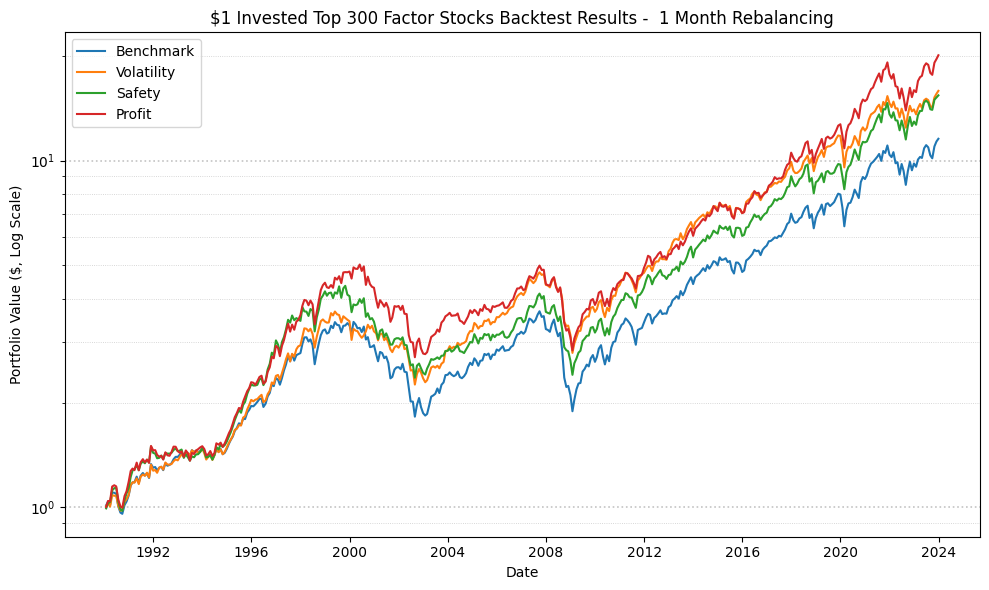

In [415]:
tvol_bt_port = tvol_monthly_returns.cumsum().apply(np.exp)
safety_bt_port = safety_monthly_returns.cumsum().apply(np.exp)
profit_bt_port = profit_monthly_returns.cumsum().apply(np.exp)

bt_plot_perf = pd.DataFrame()
bt_plot_perf['Benchmark'] = tvol_bt_port['Benchmark'] 
bt_plot_perf['Volatility'] = tvol_bt_port['Portfolio'] 
bt_plot_perf['Safety'] = safety_bt_port['Portfolio'] 
bt_plot_perf['Profit'] = profit_bt_port['Portfolio'] 

one_dollar_invested_plot(bt_plot_perf, "$1 Invested Top 300 Factor Stocks Backtest Results -  1 Month Rebalancing", save_as="$1 Invested Top 300 Factor Stocks Backtest Results -  1 Month Rebalancing.png")

resample the backtest to show simple yearly return

In [416]:
bt_yby = pd.DataFrame({
    'Volatility':    tvol_monthly_returns['Active'].resample('YE').sum(),
    'Safety':        safety_monthly_returns['Active'].resample('YE').sum(),
    'Profitability': profit_monthly_returns['Active'].resample('YE').sum(),
}).apply(np.expm1) #convert to simple yearly return in much the same way as the yearly graphs in part 1 
bt_yby.index = bt_yby.index.year

bt_yby.head()

,Volatility,Safety,Profitability
date,,,
1990,0.003948,0.051751,0.094693
1991,-0.023797,0.048858,0.025222
1992,-0.002941,-0.058629,-0.073549
1993,0.017048,-0.043078,-0.029374
1994,0.015345,0.056076,0.060987


make into a tidy graph

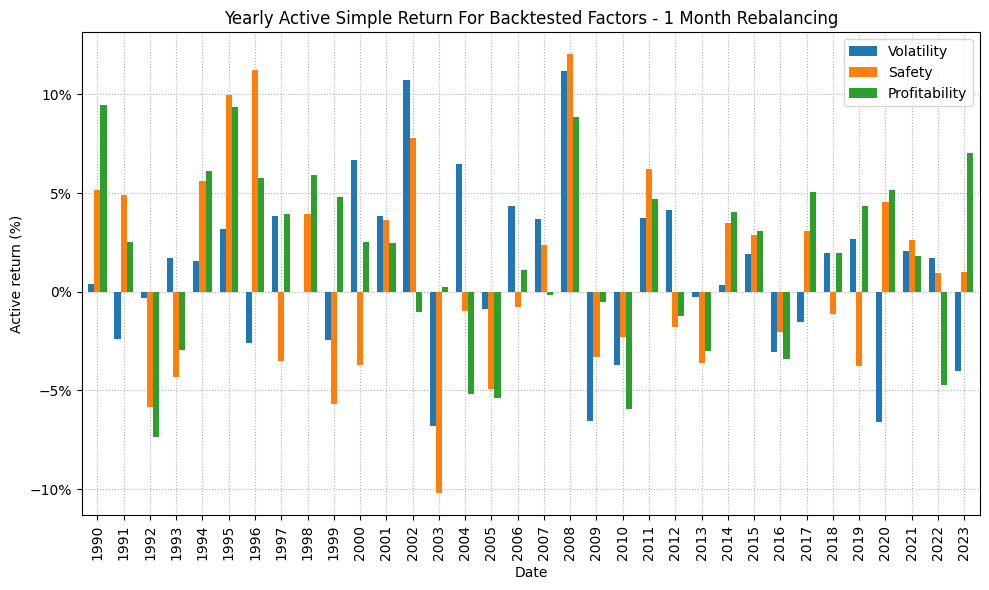

In [417]:
bt_yby_bar = bt_yby.plot(figsize=(10, 6), kind='bar',  width=0.7)
bt_yby_bar.set_title("Yearly Active Simple Return For Backtested Factors - 1 Month Rebalancing")
bt_yby_bar.set_xlabel("Date")
bt_yby_bar.set_ylabel("Active return (%)")
bt_yby_bar.grid(True, axis='both', linestyle=':', linewidth=0.8)
bt_yby_bar.set_axisbelow(True)
plt.tight_layout()
bt_yby_bar.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
bt_yby_bar.figure.savefig("bt_yby_bar.png", dpi=150, bbox_inches='tight')
plt.show()

4. REBALANCING FREQUENCY OPTIMISATION


set variables to store data from optimisation loop

In [418]:
rebalancing_freq = {
    'tvol': 0,
    'safety': 0,
    'profit': 0,
}
factor_names = ['tvol', 'safety', 'profit']
frequencies = range(1, 7) #list of 1 to 6
ir_values = pd.DataFrame(index=frequencies, columns=factor_names, dtype=float)
turnover_values = pd.DataFrame(index=frequencies, columns=factor_names, dtype=float)

optimisation loop which will be skipped if the skip flag is set to true at the top of the notebook

In [419]:
if skip_optimisation_frequency is not True:
    for factor in factor_names: #loop through the factors
        max_IR = -np.inf #set to negative infinity so that any IC is better
        for frequency in frequencies: #loop through rebalancing frequencies 1 to 6
            print(f'calculating {factor} frequency: {frequency}') #debug message
            #perfom the backtest only grabbing the turnover and performance
            _, turnover, _, perf = ap.backtesting(factors[factor], prices['price'], market_cap['market_cap'], start='1990-01-01', end='2023-12-31', frequency=frequency, t_cost=0.0015, N=300)
            #save the information ratio for graphing
            ir_values.loc[frequency, factor] = perf.loc['RR Ratio', 'Active']
            #save the turnover rate for graphing
            turnover_values.loc[frequency, factor] = turnover.mean().loc['Turnover']
            if perf.loc['RR Ratio', 'Active'] > max_IR: #if the IR is above what has been ever been seen since the start of the first loop 
                max_IR = perf.loc['RR Ratio', 'Active'] #save new max
                rebalancing_freq[factor] = frequency # set saved value to max

    print(rebalancing_freq) # optimised values

graph the optimsed values - if the optimisation is skipped these grahps will be empty

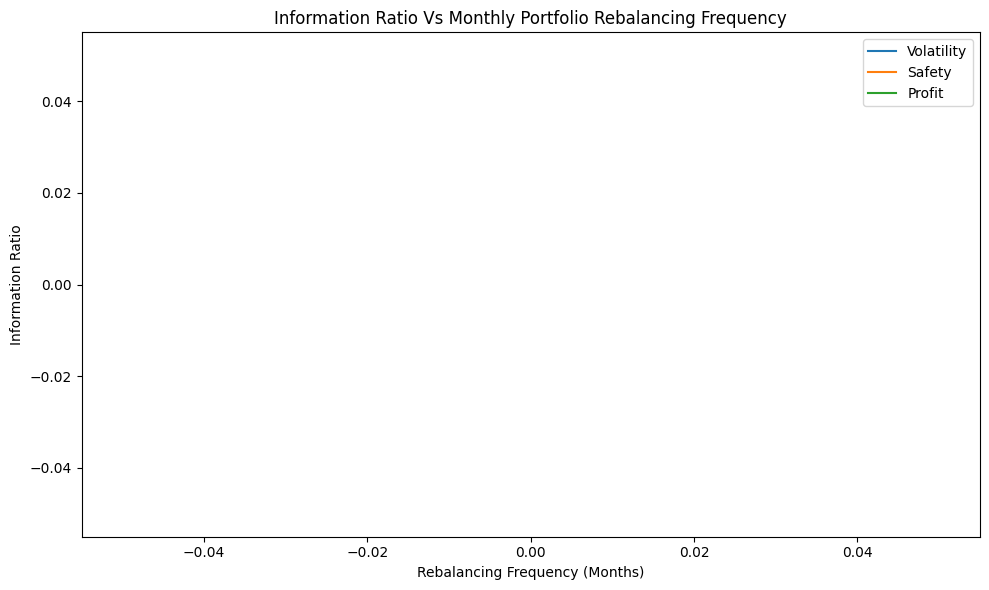

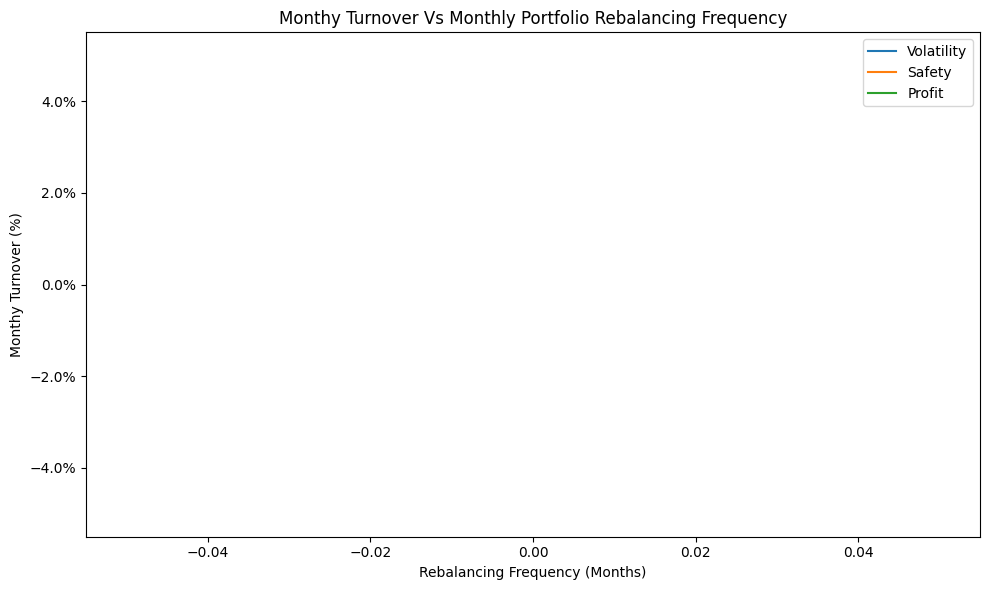

In [420]:
ir_values_plot = ir_values.plot(figsize=(10, 6))
ir_values_plot.set_title("Information Ratio Vs Monthly Portfolio Rebalancing Frequency")
ir_values_plot.set_ylabel("Information Ratio")
ir_values_plot.set_xlabel("Rebalancing Frequency (Months)")

legend_map = {
        "tvol" : "Volatility",
        "safety" : "Safety",
        "profit" : "Profit",
}
handles, labels = ir_values_plot.get_legend_handles_labels()
ir_values_plot.legend(handles, [legend_map.get(l, l) for l in labels])
ir_values_plot.figure.tight_layout()
ir_values_plot.figure.savefig("ir_values_plot.png", dpi=150, bbox_inches='tight')

#plot for the turnover
turnover_plot = turnover_values.plot(figsize=(10, 6))
turnover_plot.set_title("Monthy Turnover Vs Monthly Portfolio Rebalancing Frequency")
turnover_plot.set_ylabel("Monthy Turnover (%)")
turnover_plot.set_xlabel("Rebalancing Frequency (Months)")
handles, labels = turnover_plot.get_legend_handles_labels()
turnover_plot.legend(handles, [legend_map.get(l, l) for l in labels])
turnover_plot.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
turnover_plot.figure.tight_layout()
turnover_plot.figure.savefig("turnover_plot.png", dpi=150, bbox_inches='tight')

# 5. OPTIMAL FACTOR COMBINATION


In [421]:
combo_data = factors.join(future_returns.to_frame())

fac_cols = ['tvol', 'profit', 'safety']

#put all factors ic in one table
ic_table = pd.concat([monthly_ic(combo_data, f) for f in fac_cols], axis=1)

#factor momentum statistical evidence
ic_persistence = ic_table.corrwith(ic_table.shift(1)) #closer to one means that high IC tends to be followed with high IC (predictive power)
print(ic_persistence) #as seen in table 4 in the report

tvol_IC      0.134740
profit_IC    0.168800
safety_IC    0.004667
dtype: float64


add the ic values to the combo data dataframe so they can be used for calculating the combination strategy

In [422]:
combo_data = combo_data.join(ic_table.shift(1))
combo_data.head()

tvol    profit    safety   fut_ret   tvol_IC  profit_IC  \
id    date                                                                      
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458  0.244678   0.054430   
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916  0.019485   0.076054   
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987  0.029740   0.118991   
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988  0.136196   0.053431   
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268  0.124002   0.071222   

                  safety_IC  
id    date                   
10001 1996-07-31   0.118534  
      1996-08-30   0.058823  
      1996-09-30   0.108931  
      1996-10-31   0.123589  
      1996-11-29   0.087373

setting up the variables for backtesting/optimising the strategy

In [423]:
#backtesting
N = 300
frequency = 5
rt_cost = 0.0015

tvol_ic_multi = 0.25
profit_ic_multi = 0.25

train_start_date: str = '1990-01-01'
train_end_date: str = '2023-12-29'

#create the values to be tested
val_range = np.linspace(0, 2, 100)

#storage for the current multiples to be tested, optimal ones so far and the max result so far
curr_multis = [0, 0, 0]
opt_multis = [0, 0, 0]
max_res = [0, 0, 0]

backtesting/optimising the strategy - this will be skipped if the skip optimisation flag at the top of the notebook is set to true - and it probably should be - last time it ran it look 40 minutes.

In [424]:
if not skip_optimisation_combo_strat:
    for j in range(0, 3): #rerunning the main optimisation loops with already optimised values so that value 0 is optimised given new values for 1 and 2 a and same for 1 and 2, a few times round to get the right balance
        #main optimisation loop
        for i in range(0, len(curr_multis)):#loop over the variables to be optimised
            for val in val_range: #for each value in the testing range
                curr_multis[i] = val #set the current value to the value from the range
                #calculate the combo factor - this is the equation written out in section 5 of the report
                combo_data['ic_multi_combo'] = ( 
                    (combo_data['tvol']   * (1+curr_multis[0]*combo_data['tvol_IC'])) +
                    (combo_data['profit'] * (1+curr_multis[1]*combo_data['profit_IC'])) +
                    (combo_data['safety'] * (1+curr_multis[2]*combo_data['safety_IC']))
                )
                #run the backtest
                _, _, _, perf = ap.backtesting(combo_data['ic_multi_combo'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
                #grab the ir
                ir = perf.loc['RR Ratio', 'Active']
                print(f'testing: {val} for multi: {i}, ir: {ir}')
                #check for max and if so save
                if ir > max_res[i]:
                    max_res[i] = ir
                    opt_multis[i] = val
                    print(f'new optimal for value {i}: {val}')

            #change the current multi value for the variable just optimised to the optimised value so that it is used when optimising the next value    
            curr_multis[i] = opt_multis[i]

        print(f'optimal multiples: {opt_multis}')
    print(f'optimal multiples: {opt_multis}')

now that we have the optimised values we can calculate the signal and use in a backtest along with a backtest of all the other factors and graph it!

In [ ]:
combo_data['ic_multi_combo'] = (
            (combo_data['tvol']   * (1+0.262*combo_data['tvol_IC'])) +
            (combo_data['profit'] * (1+1.515*combo_data['profit_IC'])) +
            (combo_data['safety'] * (1+0.464*combo_data['safety_IC']))
        )

factor_combo_rets, _, _, perf = ap.backtesting(combo_data['ic_multi_combo'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
print(perf)

              Portfolio  Benchmark    Active
Mean Return    0.091942   0.071975  0.019967
St. Dev.       0.132006   0.140972  0.033513
RR Ratio       0.696498   0.510561  0.595809
% Positive     0.634804   0.634804  0.541667
Worst Month   -0.145358  -0.186303 -0.029301
Best Month     0.122624   0.109437  0.040945
Max DrawDown  -0.492276  -0.608557 -0.064576


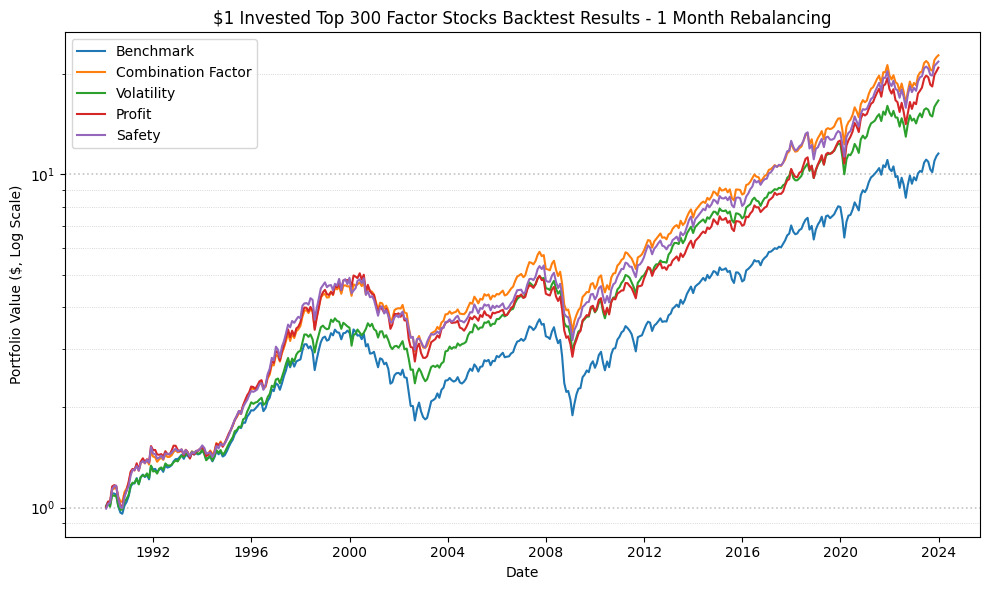

In [426]:
#individual factors backtesting - just keep returns
tvol_ret, _, _, _ = ap.backtesting(combo_data['tvol'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
profit_ret, _, _, _ = ap.backtesting(combo_data['profit'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)
safety_ret, _, _, _ = ap.backtesting(combo_data['safety'], prices['price'], market_cap['market_cap'], start=train_start_date, end=train_end_date, frequency=frequency, t_cost=rt_cost, N=N)

#caculate the $1 return on the benchmark and limit it to just 1990 and beyond
bench_port = combo_data['fut_ret'].groupby('date').mean().loc['1990-01-01':].cumsum().apply(np.exp).to_frame()
#calculate the $1 return for the backtests
factor_combo_port = factor_combo_rets['Portfolio'].cumsum().apply(np.exp).to_frame()
tvol_port = tvol_ret['Portfolio'].cumsum().apply(np.exp).to_frame()
profit_port = profit_ret['Portfolio'].cumsum().apply(np.exp).to_frame()
safety_port = safety_ret['Portfolio'].cumsum().apply(np.exp).to_frame()

#put it all in one dataframe ready to plot
plot_df = pd.DataFrame()
plot_df['Benchmark'] = bt_plot_perf['Benchmark']
plot_df['Combination Factor'] = factor_combo_port['Portfolio']
plot_df['Volatility'] = tvol_port['Portfolio']
plot_df['Profit'] = profit_port['Portfolio']
plot_df['Safety'] = safety_port['Portfolio']

#plot and save - figure 12 in the report
one_dollar_invested_plot(plot_df, "$1 Invested Top 300 Factor Stocks Backtest Results - 1 Month Rebalancing", save_as="combination factor graph")

6. MACHINE LEARNING FACTOR INVESTING APPROACH

recreate combo_data to revert changes made in section 5.

In [427]:
#recreate combo_data to revert changes made in section 5.
combo_data = factors.join(future_returns.to_frame())

create the tree which just uses the 3 factors

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
         Feature Importance
tvol               0.78948
profit             0.21052
safety             0.00000


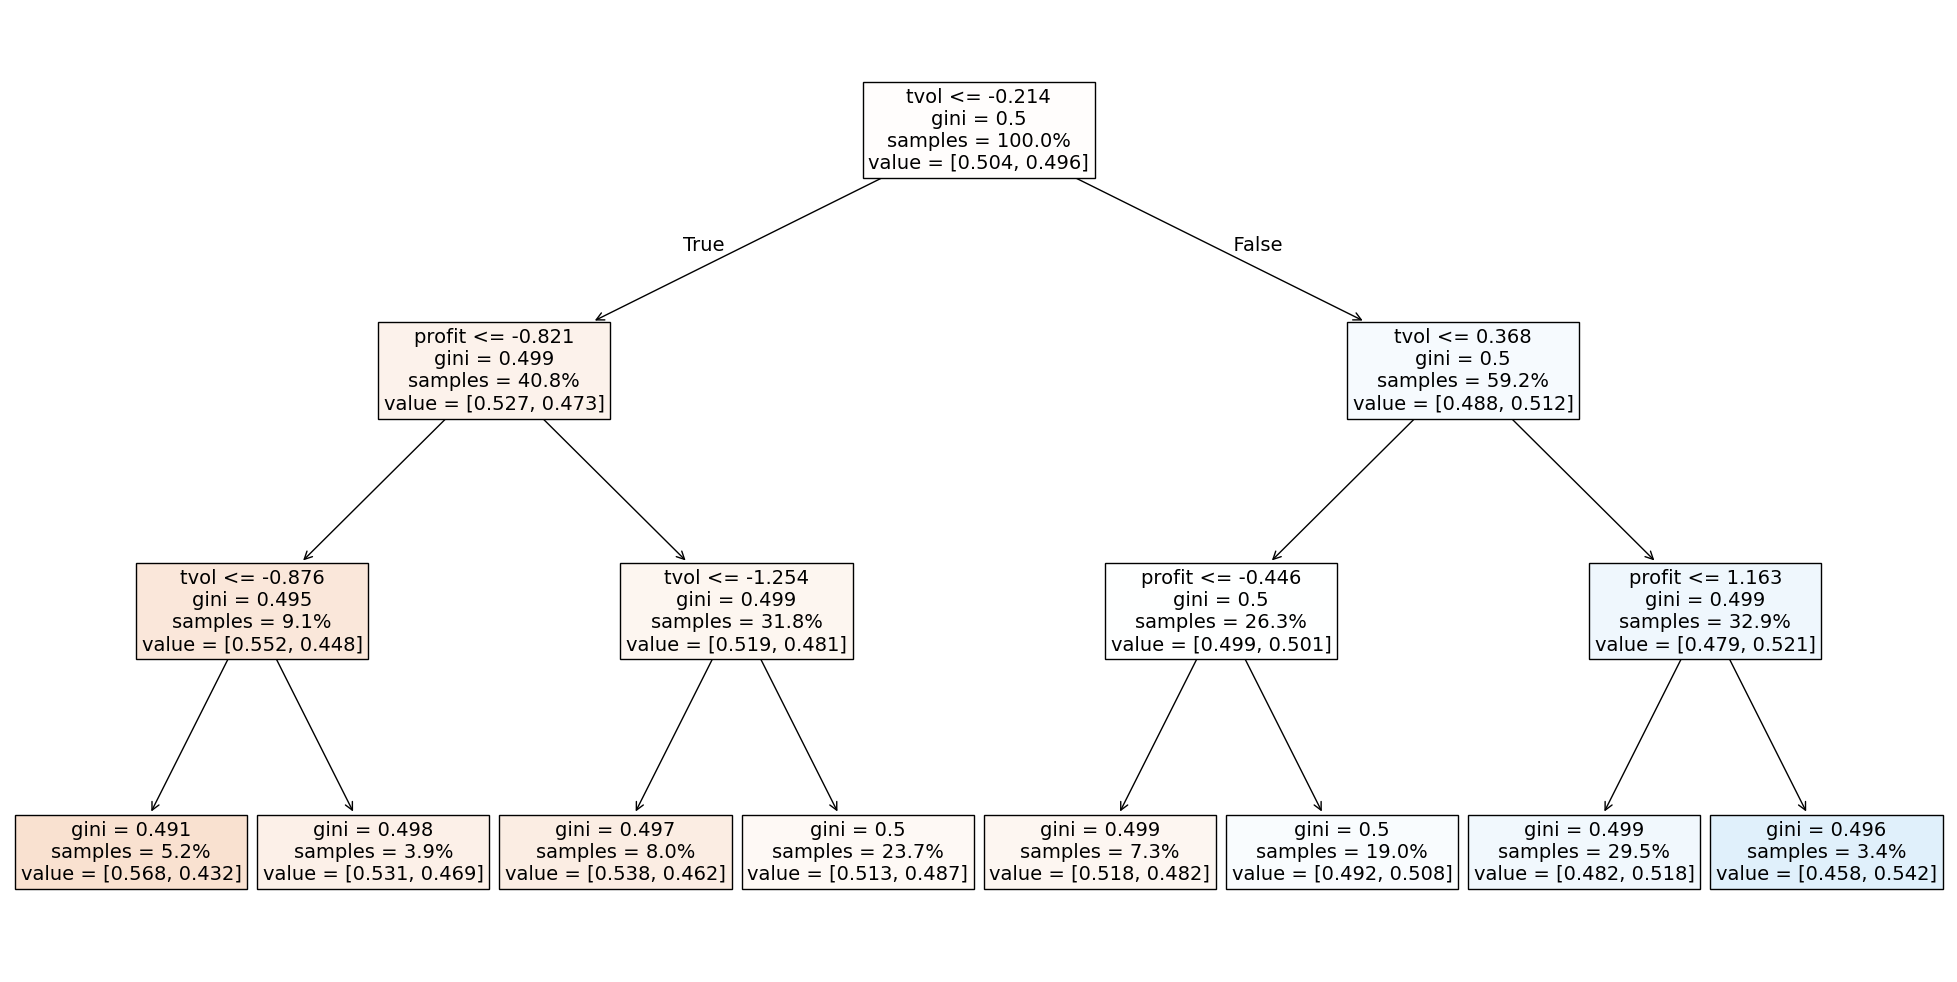

In [ ]:
#calculate a decision tree for combo data using the train tree function to make it nice and tidy
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data, prices, depth=3)
plt.figure(figsize=(30/1.2,15/1.2)) # figsize optimised to look nice in the report
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
plt.savefig("decision_tree_1.png", dpi=150, bbox_inches='tight')
print(f'feature_importance: \n {feature_importance}')

add the inflation rate to the data for the next tree

In [ ]:
combo_data_inf = combo_data.join(inflation['Inflation'])
combo_data_inf.head()

tvol    profit    safety   fut_ret  Inflation
id    date                                                         
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458   3.083473
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916   3.063090
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987   2.943742
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988   2.980390
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268   3.056422

create the next tree which has access to the inflation rate

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.028216  0.057543   0.017079  0.040464  0.085759
St. Dev.      0.245578  0.173608   0.204071  0.049543  0.105132
RR Ratio     -0.114896  0.331455   0.083691  0.816761  0.815730
% Positive    0.518519  0.620370   0.564815  0.648148  0.648148
Worst Month  -0.335507 -0.213798  -0.272953 -0.050638 -0.108292
Best Month    0.203964  0.136353   0.168014  0.059155  0.121709
Max DrawDown -0.573584 -0.351279  -0.439564 -0.172271 -0.365832
in sample accuracy: 0.5205771738624191, out of sample accuracy: 0.5180845089311908
feature_importance: 
            Feature Importance
tvol                 0.695594
profit               0.174030
safety               0.000000
Inflation            0.130376
['tvol', 'profit', 'safety', 'Inflation']


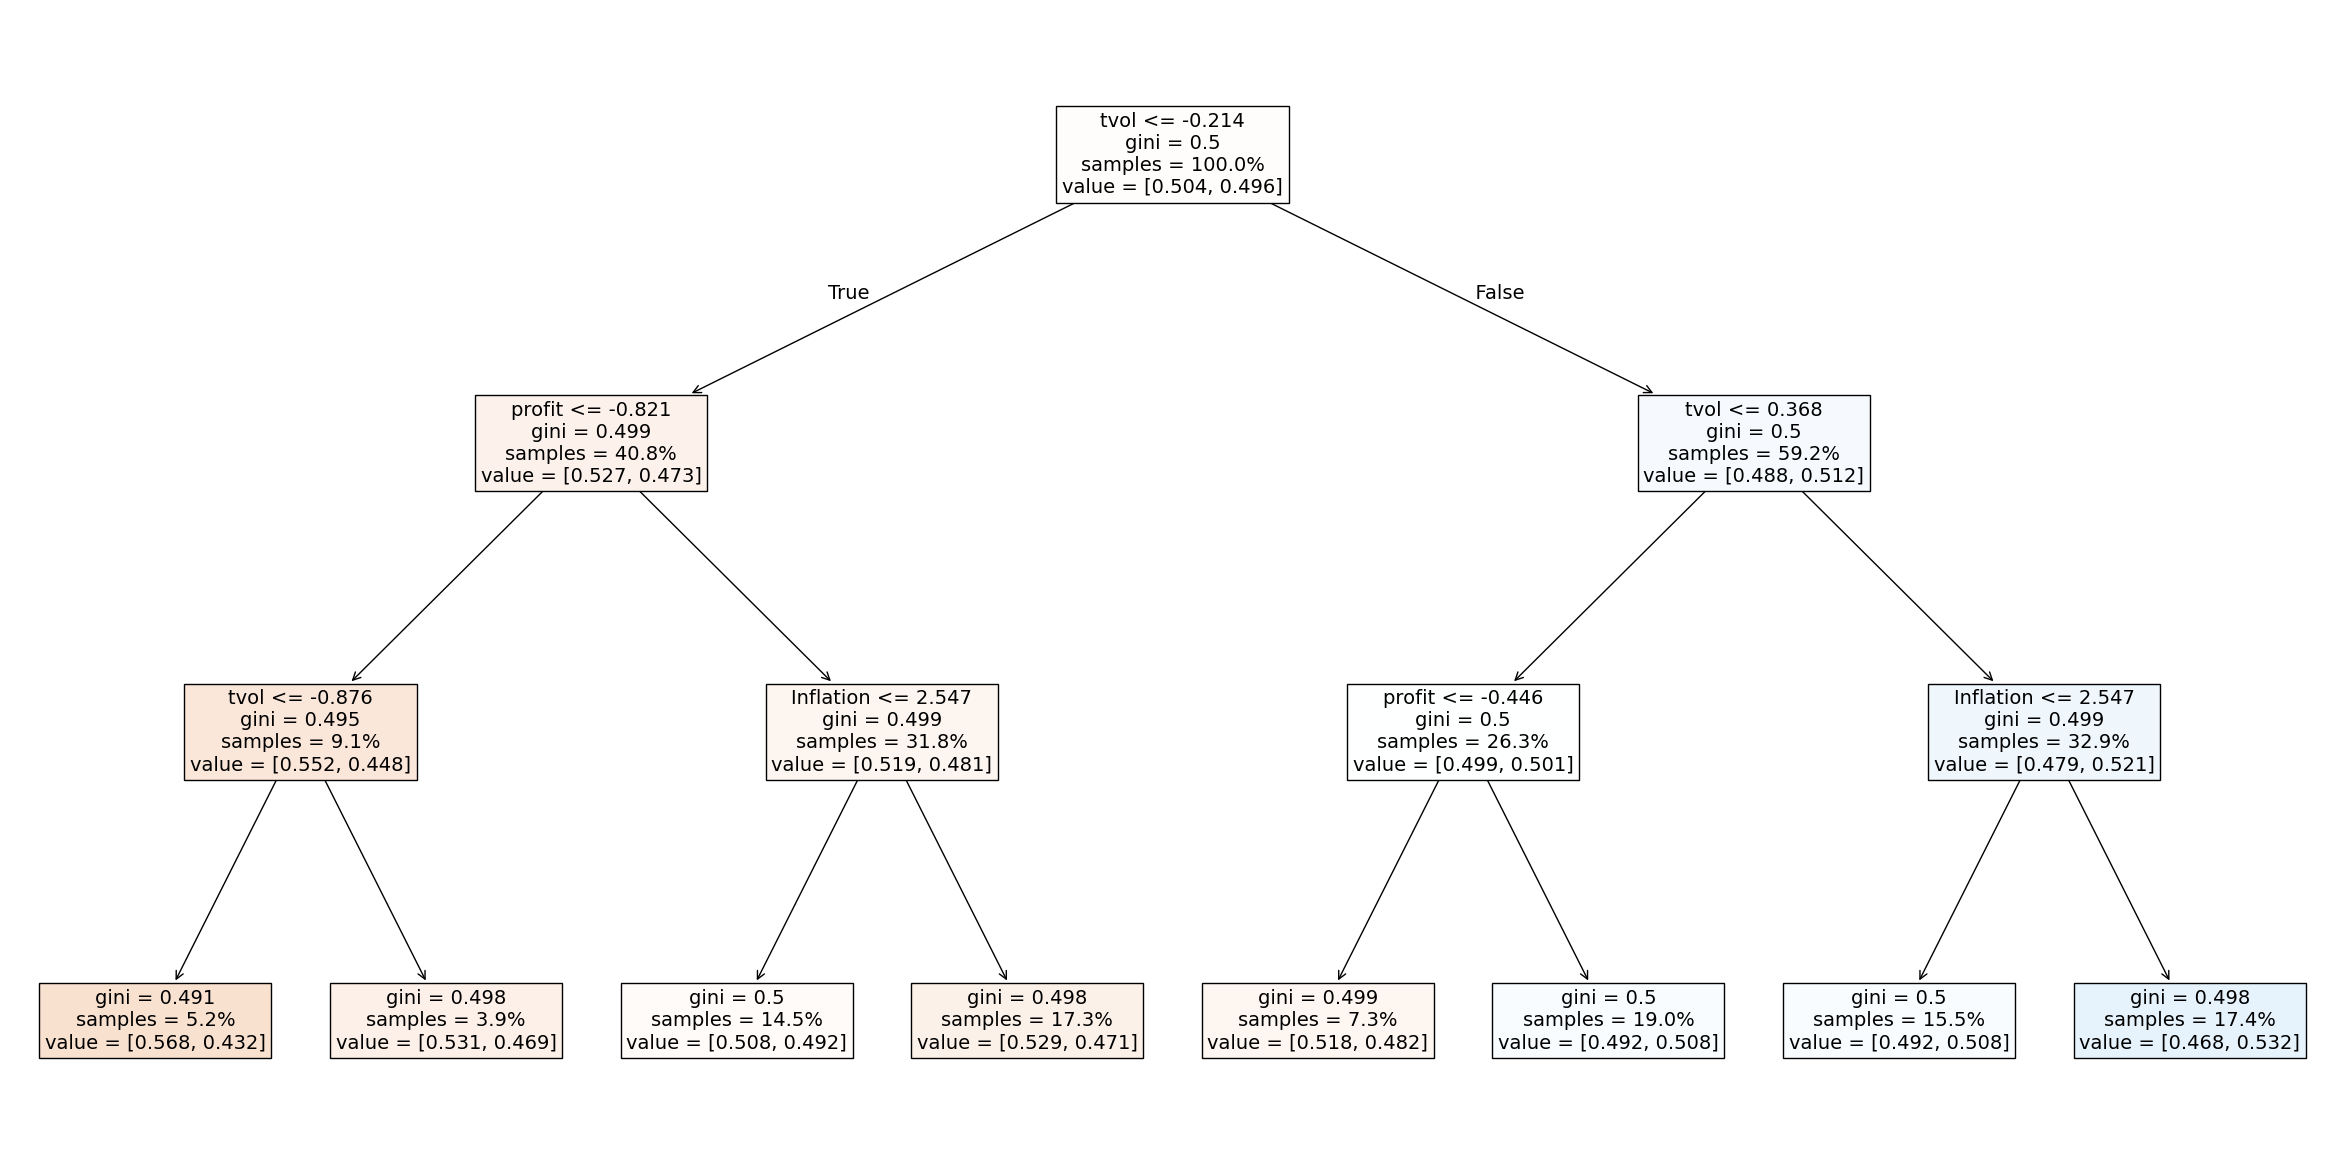

In [430]:
#re run tree with inflation variable
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_inf, prices, depth=3)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
plt.savefig("decision_tree_2.png", dpi=150, bbox_inches='tight')
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)

add the change in inflation to the dataframe for the next tree

In [431]:
combo_data_infchg = combo_data.join(inflation['Inflation'])
combo_data_infchg['inf_chng'] = combo_data_infchg['Inflation']/combo_data_infchg['Inflation'].shift(1) - 1
combo_data_infchg.head()

tvol    profit    safety   fut_ret  Inflation  inf_chng
id    date                                                                   
10001 1996-07-31  1.145514 -0.612134 -0.475430  0.037458   3.083473       NaN
      1996-08-30  1.144505 -0.614493 -0.553341  0.040916   3.063090 -0.006610
      1996-09-30  1.144190 -1.327119 -0.697980 -0.028987   2.943742 -0.038963
      1996-10-31  1.124252 -1.324461 -0.728012  0.028988   2.980390  0.012450
      1996-11-29  1.123180 -1.321322 -0.721799 -0.061268   3.056422  0.025511

re run tree with access to inflation and inflation change

                     0         1  Benchmark    Active   Neutral
Mean Return  -0.030845  0.061335   0.017079  0.044256  0.092179
St. Dev.      0.228849  0.187136   0.204071  0.039972  0.082353
RR Ratio     -0.134782  0.327754   0.083691  1.107177  1.119322
% Positive    0.527778  0.620370   0.564815  0.685185  0.685185
Worst Month  -0.273042 -0.272540  -0.272953 -0.031748 -0.067662
Best Month    0.203928  0.136266   0.168014  0.032274  0.066453
Max DrawDown -0.511232 -0.410021  -0.439564 -0.097945 -0.186121
in sample accuracy: 0.520882818685669, out of sample accuracy: 0.519157425335915
feature_importance: 
            Feature Importance
tvol                 0.686915
profit               0.171859
safety               0.000000
Inflation            0.055753
inf_chng             0.085473
['tvol', 'profit', 'safety', 'Inflation', 'inf_chng']


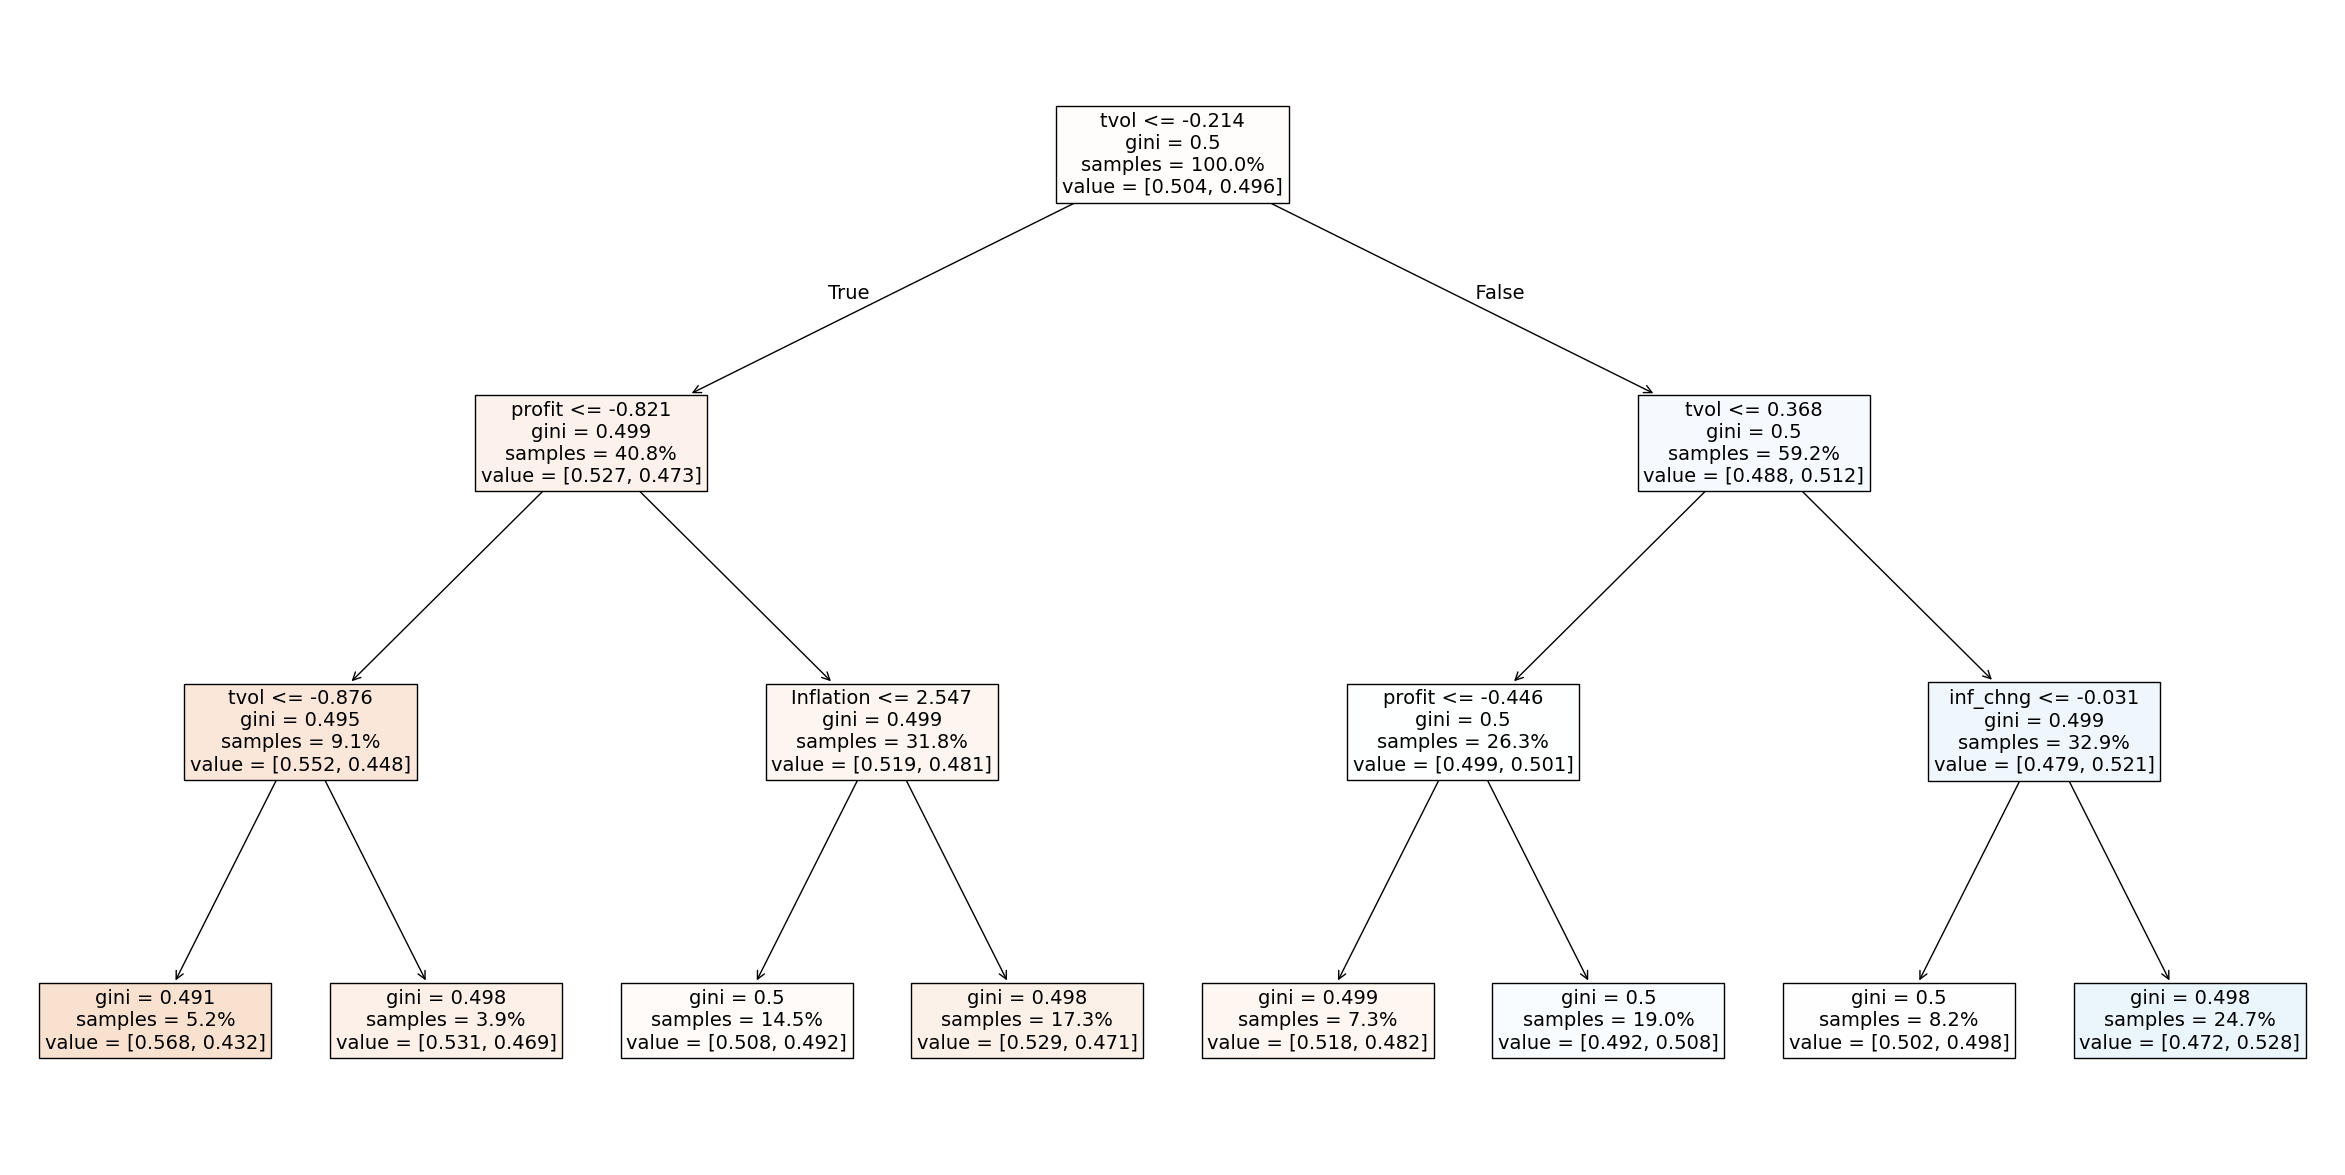

In [432]:
#re run tree with inflation change
clf, ins_accuracy, os_accuracy, ir, feature_importance, x_cols_list = train_tree(combo_data_infchg, prices, depth=3)
plt.figure(figsize=(30,15))
tree.plot_tree(clf, fontsize=14, feature_names = x_cols_list, filled=True, proportion=True)
plt.savefig("decision_tree_3.png", dpi=150, bbox_inches='tight')
print(f'feature_importance: \n {feature_importance}')
print(x_cols_list)
